# PRMT-1181 Attachment Metadata Insights

### Context

PCSE want to be able to understand the scope and size of the GP2GP fallback service. They want to know more about the types of attachments that come via GP2GP.

They would like to know:
- Average and maximum file sizes
- Graph which demonstrates distribution of file sizes
- Identify File types that got as far as the transfer
- Add graph on number of attachments

### Assumptions

#### Each row of the attachments data set represents a unique attachment.

The core assumption made in this analysis is that each row is a different attachment. However, attachment ids do not uniquely idefity a each row of data within the same GP2GP transfer, despite sizes and types of attachments nevertheless varying. One plausible explination is that attachments which are not sent via a seperate spine message recieve a generic identififer instead of a unique one. See appendix 1 for more.

#### Attachments appear in the attachments dataset shortly after the transfer is requested.

This needs to be the case if we are to calculate how many gp2gp tranfers have no attachments.

This appears to be true (within two hours) for 99% of our data. See appendix 2 for more.

### Requirements

In order to replicate this notebook, perform the following steps:

1. Log into Splunk and run the following query, for 21/12/2020 00:00:00:00 to 27/12/2020 24:00:00 and 28/12/2020 00:00:00:00 to 03/01/2020 24:00:00 time frames (currently there are issues with downloading large data sets in Splunk):

```
index="spine2vfmmonitor" logReference=MPS0208
| fields _time, attachmentID, conversationID, FromSystem, ToSystem, attachmentType, Compressed, ContentType, LargeAttachment, Length, OriginalBase64
| fields - _raw
```

2. Download the two data sets as CSVs and place in a directory called `attachments_metadata`. Set the `INPUT_DATA_DIR` environment variable to point to the _parent_ of this directory.

3. Run the following Splunk query for the same time range, and place the CSV in a directory alongside the first one called `gp2gp_requests`.

```
index="spine2vfmmonitor" service="gp2gp" interactionID="urn:nhs:names:services:gp2gp/RCMR_IN010000UK05"
| fields _time, conversationID
| fields - _raw
```

Example directory layout, where `INPUT_DATA_DIR` is `/attachments`.
```
/attachments/attachments_metadata/attachments_one.csv
/attachments/attachments_metadata/attachments_two.csv
/attachments/gp2gp_requests/requests.csv
```


In [1]:
import paths, os
import duckdb
from scripts.attachments import construct_attachments_db

In [2]:
attachment_data_dir = os.environ["INPUT_DATA_DIR"]
cursor =  duckdb.connect()
construct_attachments_db(cursor, attachment_data_dir)
attachments = cursor.table("attachment_metadata")

## Attachment types

In [3]:
(start_time, end_time) = attachments\
    .aggregate("MIN(time) as start_time, MAX(time) as end_time") \
    .execute().fetchone()

start_date = start_time.date()
end_date = end_time.date()

In [4]:
attachment_count = attachments.aggregate("COUNT(*)").df()
print(f"{attachment_count.iat[0, 0]} attachments in dataset ({start_date} to {end_date})")

2502766 attachments in dataset (2020-12-21 to 2021-01-03)


### Number of attachments by file type

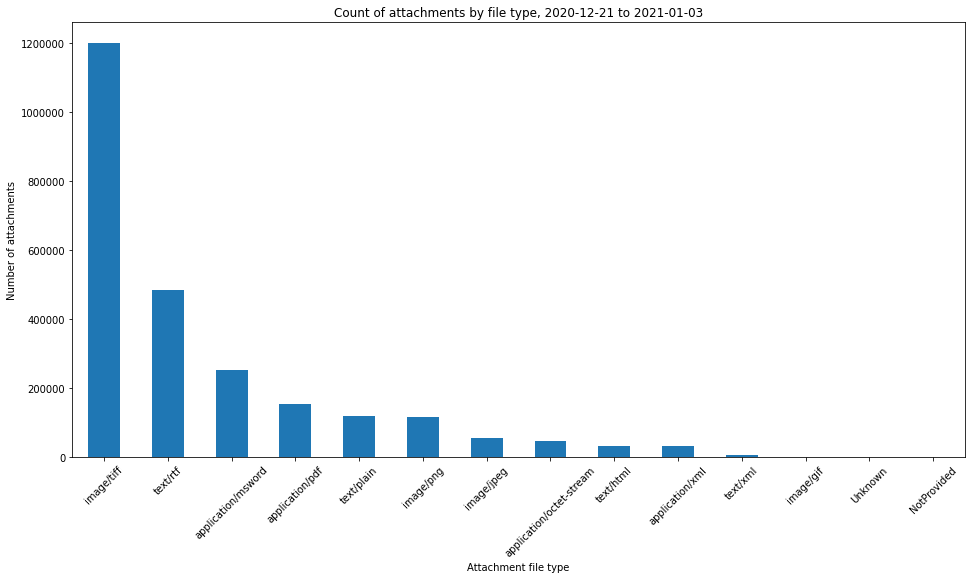

In [5]:
attachments_per_content_type = attachments.aggregate("content_type, count(*) as count").order("count DESC").df()
attachment_type_bars = attachments_per_content_type.plot.bar(
    x="content_type", y="count",
    title=f"Count of attachments by file type, {start_date} to {end_date}",
    rot=45,
    figsize=(16,8),
    legend=False,
)
attachment_type_bars.set(xlabel="Attachment file type", ylabel="Number of attachments")
attachment_type_bars.ticklabel_format(style='plain', axis='y')

In [6]:
attachments_per_content_type.set_index("content_type").style.set_caption(f"Count of attachments by file type, {start_date} to {end_date}")

,count
content_type,
image/tiff,1200968
text/rtf,483741
application/msword,252386
application/pdf,155701
text/plain,120187
image/png,116424
image/jpeg,54306
application/octet-stream,47303
text/html,33053


### Number of transfers with attachment

In [7]:
transfer_count, with_attachment_count, without_attachment_count = cursor.execute("""
    select
        count(*) as transfers,
        sum(case when attachments.conversation_id is not null then 1 else 0 end) as with_attachments,
        sum(case when attachments.conversation_id is null then 1 else 0 end) as without_attachments
    from gp2gp_requests
    left join (select distinct conversation_id from attachment_metadata) attachments
    on attachments.conversation_id=gp2gp_requests.conversation_id
""").fetchone()
percent_with_attachment = with_attachment_count/transfer_count*100
print(f"Out of {transfer_count} transfers made between {start_date} and {end_date}, {with_attachment_count} had at least one attachment. ({percent_with_attachment}%) ")

Out of 58401 transfers made between 2020-12-21 and 2021-01-03, 30056 had at least one attachment. (51.464872176846285%) 


### Number of attachments per transfer (excluding transfers with no attachments)

In [8]:
attachments_per_transfer = attachments.aggregate("conversation_id, count(*) as count").df()

In [9]:
attachments_per_transfer_truncated = attachments.aggregate("conversation_id, count(*) as count").filter("count <= 1000").df()

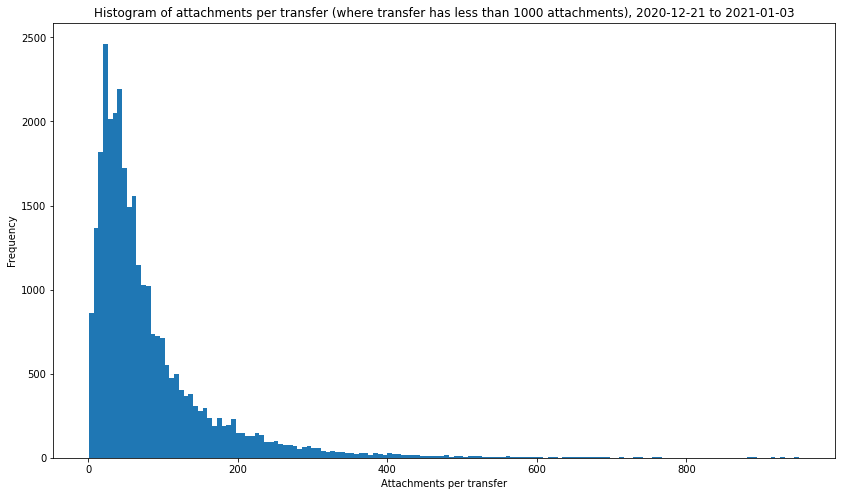

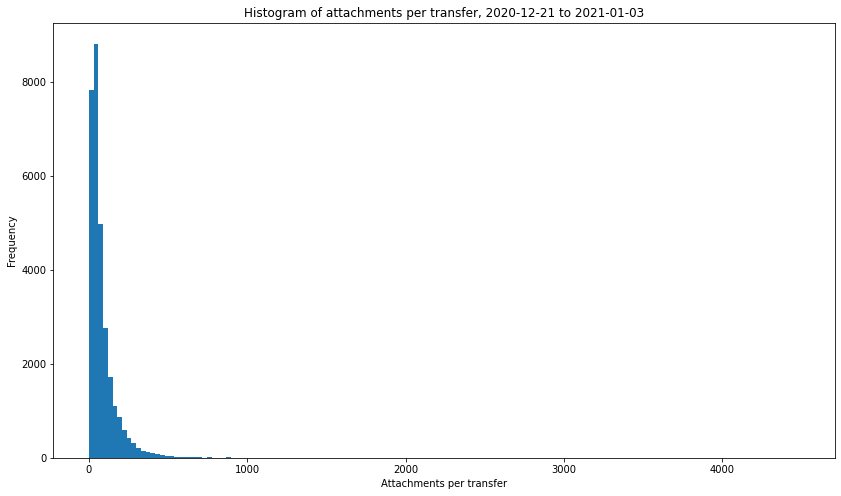

In [10]:
attachments_per_transfer_hist_truncated = attachments_per_transfer_truncated.plot.hist(
    title=f"Histogram of attachments per transfer (where transfer has less than 1000 attachments), {start_date} to {end_date}",
    legend=False,
    bins=150, figsize=(14,8)
)
attachments_per_transfer_hist = attachments_per_transfer.plot.hist(
    title=f"Histogram of attachments per transfer, {start_date} to {end_date}",
    legend=False,
    bins=150, figsize=(14,8)
)
attachments_per_transfer_hist_truncated.set(xlabel="Attachments per transfer", ylabel="Frequency")
attachments_per_transfer_hist_truncated.ticklabel_format(style='plain', axis='y')
attachments_per_transfer_hist.set(xlabel="Attachments per transfer", ylabel="Frequency")
attachments_per_transfer_hist.ticklabel_format(style='plain', axis='y')

In [11]:
attachments_per_transfer.describe().style.set_caption(f"Count of attachments per transfer, {start_date} to {end_date}")

,count
count,30314.000000
mean,82.561391
std,93.660691
min,1.000000
25%,30.000000
50%,54.000000
75%,101.000000
max,4484.000000


## Size of attachments

In [12]:
attachment_lengths = attachments.project("content_type, length/(1024.0*1024.0) as megabytes").df()

In [13]:
attachment_lengths.describe().style.set_caption(f"Attachment file sizes (megabytes), {start_date} to {end_date}")

,megabytes
count,2502726.000000
mean,0.419967
std,1.799230
min,0.000004
25%,0.018356
50%,0.049992
75%,0.179811
max,194.424458


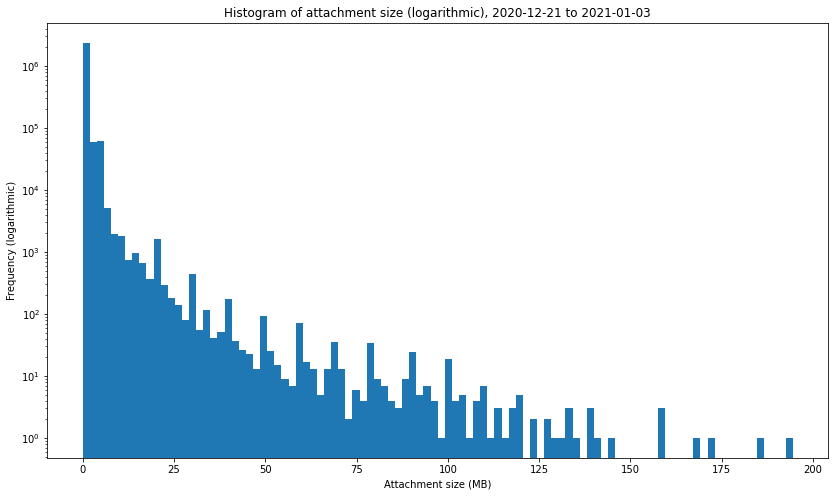

In [14]:
attachment_lengths_hist = attachment_lengths.plot.hist(
    title=f"Histogram of attachment size (logarithmic), {start_date} to {end_date}",
    legend=False,
    bins=100, log=True, figsize=(14,8)
)
attachment_lengths_hist.set(xlabel="Attachment size (MB)", ylabel="Frequency (logarithmic)")
attachment_lengths_hist.ticklabel_format(style='plain', axis='x', useOffset=False)

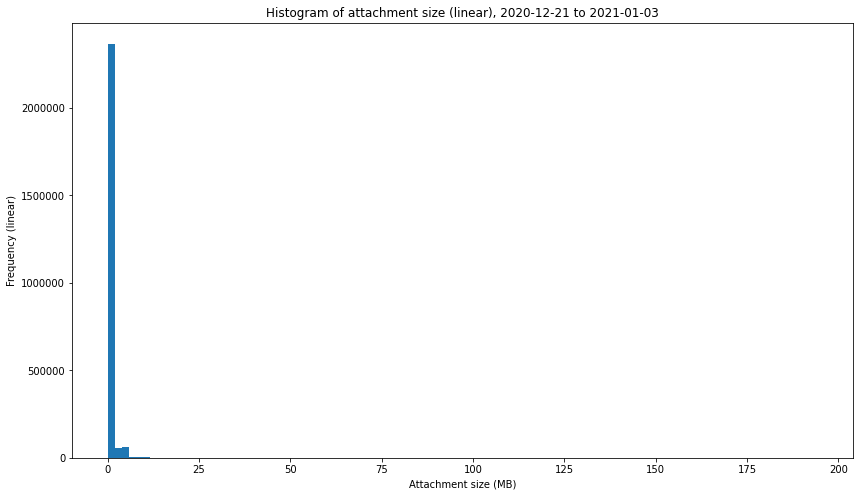

In [15]:
attachment_lengths_hist_lin = attachment_lengths.plot.hist(
    title=f"Histogram of attachment size (linear), {start_date} to {end_date}",
    legend=False,
    bins=100, log=False, figsize=(14,8)
)
attachment_lengths_hist_lin.set(xlabel="Attachment size (MB)", ylabel="Frequency (linear)")
attachment_lengths_hist_lin.ticklabel_format(style='plain', axis='y', useOffset=False)

### Attachment size by file type

In [16]:
attachment_lengths.groupby('content_type').describe().style.set_caption("Attachment file sizes by content type")


[Text(0.5, 0, 'Attachment type'), Text(0, 0.5, 'Size (MB)')]

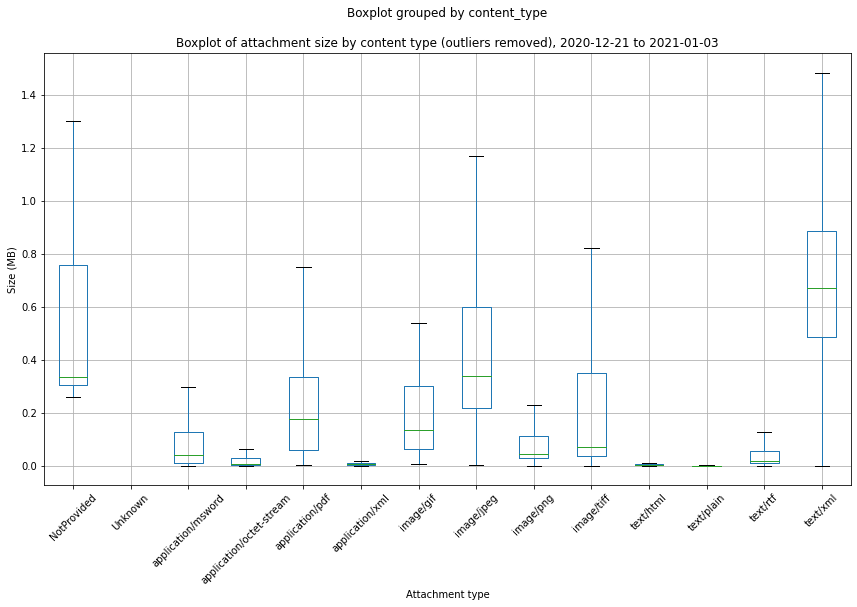

In [17]:
attachment_lengths_boxplot = attachment_lengths.boxplot(
    'megabytes', by='content_type',
    figsize=(14,8),
    showfliers=False,
    rot=45,
)
attachment_lengths_boxplot.set_title(f"Boxplot of attachment size by content type (outliers removed), {start_date} to {end_date}")
attachment_lengths_boxplot.set(xlabel="Attachment type", ylabel="Size (MB)")

## Size of combined attachments per transfer

In [18]:
combined_attachment_size = attachments.aggregate("conversation_id, SUM(length)/(1024*1024) as megabytes").df()

In [19]:
combined_attachment_size.describe().style.set_caption(f"Size of combined attachments per transfer, {start_date} to {end_date}")

,megabytes
count,30305.000000
mean,34.183468
std,67.166752
min,0.000000
25%,5.000000
50%,12.000000
75%,33.000000
max,2571.000000


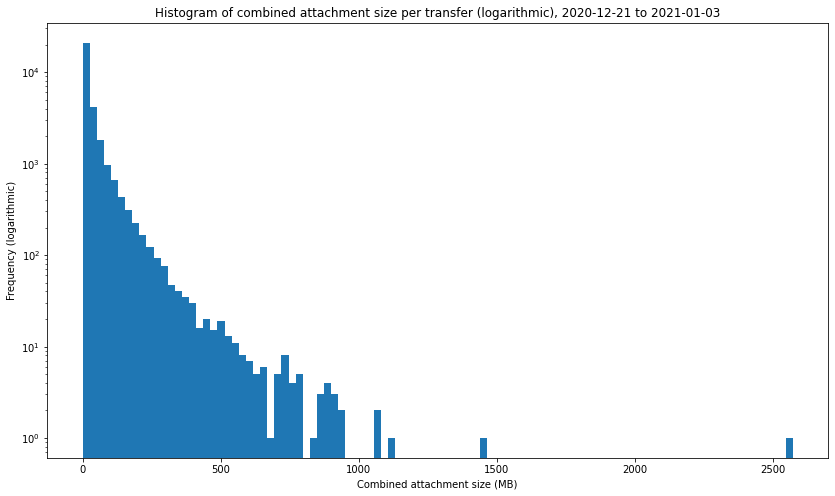

In [20]:
transfer_sizes_hist = combined_attachment_size.plot.hist(
        title=f"Histogram of combined attachment size per transfer (logarithmic), {start_date} to {end_date}",
    legend=False,
    bins=100, log=True, figsize=(14,8)
)
transfer_sizes_hist.set(xlabel="Combined attachment size (MB)", ylabel="Frequency (logarithmic)")
transfer_sizes_hist.ticklabel_format(style='plain', axis='x', useOffset=False)

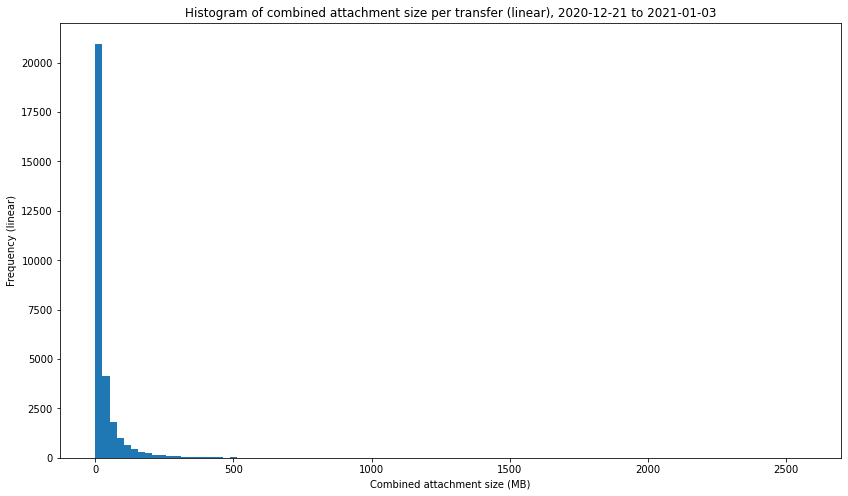

In [21]:
transfer_sizes_hist_lin = attachments.aggregate("conversation_id, SUM(length)/(1024*1024) as bytes").df().plot.hist(
        title=f"Histogram of combined attachment size per transfer (linear), {start_date} to {end_date}",
    legend=False,
    bins=100, log=False, figsize=(14,8)
)
transfer_sizes_hist_lin.set(xlabel="Combined attachment size (MB)", ylabel="Frequency (linear)")
transfer_sizes_hist_lin.ticklabel_format(style='plain', axis='x', useOffset=False)

## Appendix 1: Attachment uniqueness

In [22]:
attachments.aggregate("count(*)").df()

,count_star()
0,2502766


In [23]:
cursor.execute("select count(*) from (select distinct conversation_id, attachment_id from attachment_metadata) uniq").df()

,count_star()
0,2156437


In [24]:
cursor.execute("select count(*) from (select distinct conversation_id from attachment_metadata) uniq").df()

,count_star()
0,30314


In [25]:
converstaion_attachment_counts = attachments\
    .aggregate("conversation_id, count(*) as rows, count(distinct(attachment_id)) as unique_attachments")\
    .create_view("convo_attachment_counts")

In [26]:
attachment_types = attachments \
    .project("attachment_id, attachment_id like '%@%' as is_internal_id, attachment_type")\
    .create_view("attachment_types")
attachment_id_correctness = attachment_types \
    .project("attachment_id, case when is_internal_id = TRUE and attachment_type != 'cid' then TRUE else FALSE end as wrong_id_type")\
    .create_view("attachment_id_correctness")
    
attachment_id_correctness.aggregate("wrong_id_type, count(*) as count").df()

,wrong_id_type,count
0,False,2502766


In [27]:
attachment_types.aggregate("is_internal_id, attachment_type, count(*) as count").df()

,is_internal_id,attachment_type,count
0,True,cid,1740460
1,False,mid,762306


## Appendix 2: Combinding attachment logs and main spine logs

In [28]:
gp2gp_attachments = cursor.execute("""
    select
        count(*) as row_count,
        sum(case when gp2gp_requests.conversation_id is null then 1 else 0 end) as attachments_with_no_transfer,
        sum(case when attachments.conversation_id is null then 1 else 0 end) as transfers_with_no_attachments
    from (select distinct conversation_id from attachment_metadata) attachments
    full outer join gp2gp_requests
    on attachments.conversation_id=gp2gp_requests.conversation_id
""").df()
gp2gp_attachments



,row_count,attachments_with_no_transfer,transfers_with_no_attachments
0,58659,258.0,28345.0


In [29]:
gp2gp_requests = cursor.execute("""
    select gp2gp_requests.time as req_time, attach.time as attach_time
    FROM gp2gp_requests
    LEFT JOIN (select conversation_id, max(time) as time from attachment_metadata group by conversation_id) attach
    ON attach.conversation_id=gp2gp_requests.conversation_id
""").df()

gp2gp_requests["time_delta"] = gp2gp_requests["attach_time"] - gp2gp_requests["req_time"]
gp2gp_requests["time_delta_sec"]= gp2gp_requests["time_delta"].astype('timedelta64[s]')
gp2gp_requests["time_delta_sec"].describe(percentiles=[.25, .50, .75, .90, .99]).apply(lambda x: format(x, '.1f'))

count      30056.0
mean        2453.0
std        37358.9
min            2.0
25%           22.0
50%           41.0
75%           92.0
90%          196.0
99%         4779.0
max      1129705.0
Name: time_delta_sec, dtype: object